In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql.functions as F

spark = pyspark.sql.SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/23 10:24:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Exploration Exercises

In [48]:
# Read all three .csv files into dataframes

case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)
department = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)
source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)

fmt = "M/d/yy H:mm"
case = (
    case.withColumn("case_opened_date", F.to_timestamp("case_opened_date", fmt))
    .withColumn("case_closed_date", F.to_timestamp("case_closed_date", fmt))
    .withColumn("SLA_due_date", F.to_timestamp("SLA_due_date", fmt))
)

In [49]:
df = (
    case.join(department, 'dept_division')
    .join(source, 'source_id')
    .drop(department.dept_division)
    .drop(source.source_id)
)
df.printSchema()

root
 |-- source_id: string (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- SLA_due_date: timestamp (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)
 |-- source_username: string (nullable = true)



## 1

How many different cases are there, by department?

In [10]:
# Let's do this one with spark only.

df.groupBy('dept_name').count().show(truncate = False)

+-------------------------+------+
|dept_name                |count |
+-------------------------+------+
|Animal Care Services     |119362|
|null                     |198   |
|Solid Waste Management   |286287|
|Development Services     |1397  |
|Trans & Cap Improvements |97841 |
|Customer Service         |2889  |
|Metro Health             |5313  |
|Parks and Recreation     |19964 |
|Code Enforcement Services|321984|
|City Council             |34    |
+-------------------------+------+



## 2

Does the percentage of cases that are late vary by department?

In [100]:
# Let's do this one with spark only.

(
    df.withColumn(
        'case_late',
        F.when(F.col('case_late') == 'YES', 1).otherwise(0)
    )
    .groupBy('dept_name')
    .agg(F.mean('case_late').alias('percentage'))
    .orderBy('percentage')
    .show(truncate = False)
)

+-------------------------+-------------------+
|dept_name                |percentage         |
+-------------------------+-------------------+
|City Council             |0.0                |
|Trans & Cap Improvements |0.05651005202318047|
|Code Enforcement Services|0.07909399224806202|
|Solid Waste Management   |0.11781533915266848|
|Metro Health             |0.16073781291172595|
|Parks and Recreation     |0.1908435183329994 |
|Animal Care Services     |0.19898292588931152|
|Development Services     |0.6012884753042234 |
|null                     |0.6666666666666666 |
|Customer Service         |0.7043959847698166 |
+-------------------------+-------------------+



## 3

On average, how late are the late cases by department?

In [18]:
# Let's do this one with spark only

(
    df.where(F.col('case_late') == 'YES')
    .groupBy('dept_name')
    .agg(F.mean(df.num_days_late))
    .show(truncate = False)
)

+-------------------------+------------------+
|dept_name                |avg(num_days_late)|
+-------------------------+------------------+
|Animal Care Services     |23.44672963473822 |
|null                     |210.89201994318182|
|Solid Waste Management   |7.147172789557422 |
|Development Services     |67.22248485687264 |
|Trans & Cap Improvements |10.66295045507867 |
|Customer Service         |88.18248182589824 |
|Metro Health             |6.494699602827868 |
|Parks and Recreation     |22.427807192724128|
|Code Enforcement Services|48.085502375106735|
+-------------------------+------------------+



## 4

What is the service type that is the most late? Just for Parks & Rec?

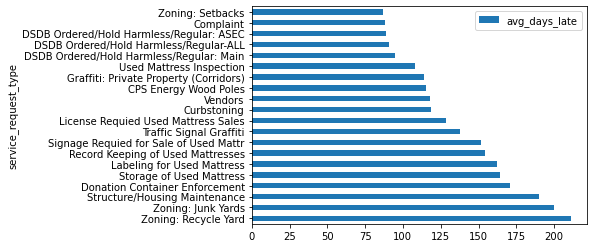

In [28]:
# Let's do this one with pandas and spark.
# We'll define most late as most late in terms of average days late, considering only late cases.

(
    df.where(F.col('case_late') == 'YES')
    .groupBy('service_request_type')
    .agg(F.mean(df.num_days_late).alias('avg_days_late'))
    .orderBy('avg_days_late', ascending = False)
    .toPandas()
    .head(20)
    .set_index('service_request_type')
    .plot.barh()
);

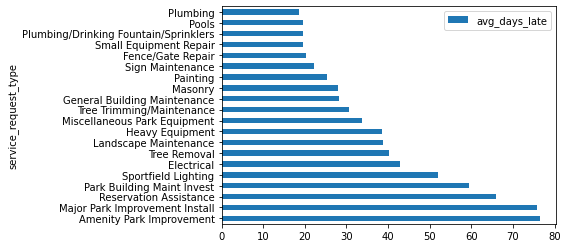

In [29]:
# Just for Parks & Rec

(
    df.where((F.col('case_late') == 'YES') & (F.col('dept_name') == 'Parks and Recreation'))
    .groupBy('service_request_type')
    .agg(F.mean(df.num_days_late).alias('avg_days_late'))
    .orderBy('avg_days_late', ascending = False)
    .toPandas()
    .head(20)
    .set_index('service_request_type')
    .plot.barh()
);

## 5

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

<AxesSubplot:ylabel='service_request_type'>

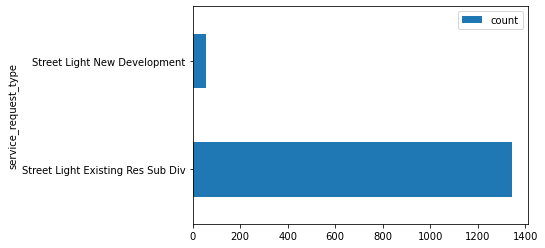

In [34]:
# Let's do this one with pandas and spark.

# DSD/Code Enforcement: department name, Development Services
(
    df.where(F.col('dept_name') == 'Development Services')
    .groupBy('service_request_type')
    .count()
    .orderBy('count', ascending = False)
    .toPandas()
    .set_index('service_request_type')
    .plot.barh()
)

<AxesSubplot:ylabel='service_request_type'>

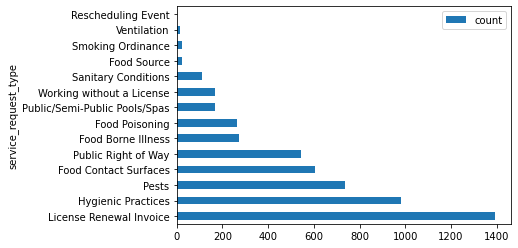

In [35]:
# Metro Health

(
    df.where(F.col('dept_name') == 'Metro Health')
    .groupBy('service_request_type')
    .count()
    .orderBy('count', ascending = False)
    .toPandas()
    .set_index('service_request_type')
    .plot.barh()
)

## 6

Does whether or not its a weekend matter for when a case is opened/closed?

In [61]:
# Let's do this one with pandas and spark.

# Get the number of cases opened on each day of the week.
cases_opened_by_day = (
    df.withColumn('day', F.date_format('case_opened_date', 'E'))
    .groupBy(F.col('day'))
    .count()
    .na.drop()
    .sort('day')
    .toPandas()
    .set_index('day')
)

cases_opened_by_day.columns = ['cases_opened']
cases_opened_by_day

,cases_opened
day,
Fri,145242
Mon,155781
Sat,54593
Sun,29343
Thu,155919
Tue,164608
Wed,149783


In [62]:
# Get the number of cases closed on each day of the week.
cases_closed_by_day = (
    df.withColumn('day', F.date_format('case_closed_date', 'E'))
    .groupBy(F.col('day'))
    .count()
    .na.drop()
    .sort('day')
    .toPandas()
    .set_index('day')
)

cases_closed_by_day.columns = ['cases_closed']
cases_closed_by_day

,cases_closed
day,
Fri,131026
Mon,136994
Sat,62327
Sun,27276
Thu,148120
Tue,157360
Wed,173833


In [69]:
# Combine the cases opened and cases closed dataframes.
cases_by_day = pd.concat([cases_opened_by_day, cases_closed_by_day], axis = 1)
cases_by_day = cases_by_day.reindex(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
cases_by_day

,cases_opened,cases_closed
day,,
Sun,29343,27276
Mon,155781,136994
Tue,164608,157360
Wed,149783,173833
Thu,155919,148120
Fri,145242,131026
Sat,54593,62327


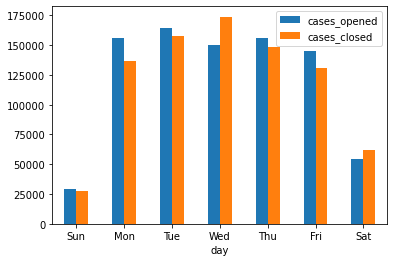

In [71]:
cases_by_day.plot.bar()
plt.xticks(rotation = 0);

## 7

On average, how many cases are opened a day for the Customer Service department?

In [76]:
# Let's do this one with a random sample.

sample = df.sample(fraction = 0.1, seed = 24).toPandas()
sample.shape

(85495, 18)

In [79]:
# Filter by the Customer Service department and set the case_opened_date column as the index.
cust_service = sample[sample.dept_name == 'Customer Service'].set_index('case_opened_date')
cust_service.head()

,source_id,dept_division,case_id,case_closed_date,SLA_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,request_address,council_district,dept_name,standardized_dept_name,dept_subject_to_SLA,source_username
case_opened_date,,,,,,,,,,,,,,,,,
2018-01-02 15:22:00,ns16326,311 Call Center,1014130342,NaT,2018-01-09 15:22:00,YES,211.359491,NO,Complaint,7.000000,Open,"711 SMOKE TREE, San Antonio, 78227",6,Customer Service,Customer Service,YES,Norma K. Sotoodeh
2018-01-12 07:59:00,jw10936,311 Call Center,1014155066,2018-01-12 08:05:00,2018-01-24 08:30:00,NO,-12.017269,YES,Compliment,12.021146,Closed,"200 LIVELY, San Antonio, 78213",1,Customer Service,Customer Service,YES,Jessica West
2018-01-17 16:37:00,139342,311 Call Center,1014169409,2018-01-19 10:01:00,2018-01-24 16:37:00,NO,-5.275023,YES,Complaint,7.000000,Closed,"131 MONTICELLO CT, San Antonio, 78223",3,Customer Service,Customer Service,YES,Jessica Mendoza
2018-01-23 10:53:00,138810,311 Call Center,1014186374,NaT,2018-01-30 10:53:00,YES,190.546273,NO,Complaint,7.000000,Open,"839 VERMONT, San Antonio, 78211",5,Customer Service,Customer Service,YES,Tawona Martin
2018-01-24 10:49:00,ld04403,311 Call Center,1014189724,2018-01-24 10:50:00,2018-02-02 10:49:00,NO,-8.998924,YES,Compliment,9.000000,Closed,"3100 NEPTUNE, San Antonio, 78226",5,Customer Service,Customer Service,YES,Laura Davis


In [86]:
# Get the average cases open per day.
cust_service.resample('d').case_id.count().mean()

0.48027444253859347

## 8

Does the number of service requests for the solid waste department vary by day of the week?

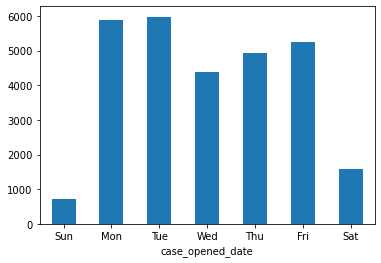

In [96]:
# Let's use the sample again.

# We'll specifically look at case_opened_date to determine if a service request was made.
solid_waste = sample[sample.dept_name == 'Solid Waste Management'].set_index('case_opened_date')

(
    solid_waste.groupby(solid_waste.index.strftime('%a'))
    .case_id
    .count()
    .reindex(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    .plot.bar()
)
plt.xticks(rotation = 0);